In [164]:
import deeptrack as dt
from deeptrack.models.yolo import utils
import numpy as np
import matplotlib.pyplot as plt

from simulation import *

In [176]:
sim= MultiParticle(
    
    
    n_particles = lambda: int(np.random.rand()*10) + 15,
        
    
)
#print('a', np.array(sim[1]) )
starting_value = dt.Value(lambda: np.ones((IMAGE_SIZE, IMAGE_SIZE)))
particle = starting_value >> sim[0]
pos = starting_value >> sim[1]
#rad = starting_value >> sim[2]





In [186]:
print(pos.resolve())
#print(rad.resolve())

Image(array([[65.59816655, 37.04164468],
       [70.74017878, 25.48540741],
       [60.23361373, 29.8634604 ],
       [53.49572258,  0.95781967],
       [ 1.10488681, 16.53747364],
       [87.7676624 ,  9.76663153],
       [99.42240337, 32.2822032 ],
       [95.93205788, 11.80538381],
       [33.50409547, 79.5402092 ],
       [34.33616156, 45.04502021],
       [70.59929106, 62.20279585],
       [59.95559708, 49.9229553 ],
       [88.20735314, 44.21970637],
       [18.87617157, 74.1250557 ],
       [30.48136185, 60.23936831],
       [25.03675429, 30.21704023],
       [64.1653206 , 74.92107709],
       [60.41281261,  2.31172035]]))


In [187]:
gradient = dt.IlluminationGradient(
    gradient=[.5e-3, 0e-3],#lambda: 1e-3 + np.random.randn(2) * 1e-3,
)

class Normalize(dt.Feature):
    def __init__(
        self, **kwargs
    ):
        super().__init__( **kwargs)

    def get(self, image, **kwargs):
        image = image / np.max(image)
        return image

normalization = Normalize()

gauss = dt.Gaussian(mu = 0, sigma = .01)

import scipy
#Smoothing
kernel = np.ones((3, 3)) / 15
smoothing = dt.Lambda(lambda: lambda image: scipy.ndimage.filters.convolve(image, kernel)) 

particle = particle >>  smoothing  >>gauss >> normalization 

In [189]:
"""def get_label(a, b):
    a = a.resolve()
    b = b.resolve()
    n = int(np.shape(a)[0])
    label = np.zeros((n,4))

    for i in range(n):
        label[i,:] = [int(a[i, 0]), int(a[i, 1]), b[i], b[i]]

    
    return label #(np.asarray(a.resolve()), np.asarray(b.resolve()))"""

def get_label(x):
    print(x)
    
    n = int(np.shape(x)[0])
    
    label = np.zeros((n, 4))

    for i in range ( n ):
        label[i, : ] = [int(x[i, 0]), int(x[i, 1]), 2, 2]

    return label

In [190]:
#pos_and_rad = pos & rad
bboxes = pos >> get_label
#bboxes.resolve()
#data = particle & bboxes
#print(data.resolve())

Image(array([[22.24770181, 36.03139742],
       [15.8483203 , 60.26597726],
       [12.3477584 , 75.22093009],
       [62.58974323,  0.53254369],
       [60.66134855,  1.28384405],
       [28.51982197, 29.42097494],
       [46.63064002, 22.36314589],
       [89.13983367, 21.96837959],
       [49.61770365,  9.83520134],
       [39.7045664 , 28.56920259],
       [24.35951609,  3.60522093],
       [50.74102685, 48.50672772],
       [95.16490596, 66.57521313],
       [69.88471115, 65.54537467],
       [ 0.8269669 , 45.53408982],
       [54.45542453, 33.33263905],
       [ 9.27273342, 37.75733156]]))
Image(array([[22.24770181, 36.03139742],
       [15.8483203 , 60.26597726],
       [12.3477584 , 75.22093009],
       [62.58974323,  0.53254369],
       [60.66134855,  1.28384405],
       [28.51982197, 29.42097494],
       [46.63064002, 22.36314589],
       [89.13983367, 21.96837959],
       [49.61770365,  9.83520134],
       [39.7045664 , 28.56920259],
       [24.35951609,  3.60522093],
      

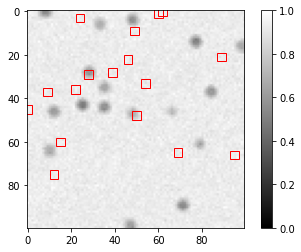

Image(array([[50.43043605, 28.77380403],
       [84.75818931, 70.15494812],
       [20.51201243, 52.07091102],
       [10.57191806, 14.63820456],
       [21.85992834, 27.14861782],
       [80.85979523, 26.4947674 ],
       [51.97539115, 51.18165881],
       [ 7.61163552, 92.11002793],
       [79.40390832, 29.11258559],
       [77.43669856, 78.48752555],
       [80.37820416, 99.37535468],
       [76.46863049, 10.84401235],
       [95.09653071, 62.90680917],
       [16.85453159, 75.47818552],
       [89.092022  , 25.79180514]]))
Image(array([[50.43043605, 28.77380403],
       [84.75818931, 70.15494812],
       [20.51201243, 52.07091102],
       [10.57191806, 14.63820456],
       [21.85992834, 27.14861782],
       [80.85979523, 26.4947674 ],
       [51.97539115, 51.18165881],
       [ 7.61163552, 92.11002793],
       [79.40390832, 29.11258559],
       [77.43669856, 78.48752555],
       [80.37820416, 99.37535468],
       [76.46863049, 10.84401235],
       [95.09653071, 62.90680917],
      

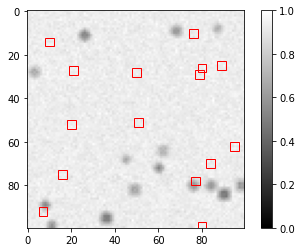

Image(array([[37.92962033, 47.77096271],
       [11.02027856, 11.92619806],
       [ 3.37781476, 34.07226279],
       [56.9669637 , 37.14159432],
       [ 6.508741  , 34.97997069],
       [38.61599141, 26.81930706],
       [ 0.90812663, 94.43551049],
       [48.4626399 , 84.99904745],
       [71.22761509, 78.35389525],
       [97.60631962, 65.25579335],
       [17.98770252, 20.82938834],
       [31.55030879,  2.01307362],
       [53.38385004, 91.7671122 ],
       [32.59099918, 64.88449075],
       [24.48440707, 46.46302117],
       [97.16693829, 88.94267956]]))
Image(array([[37.92962033, 47.77096271],
       [11.02027856, 11.92619806],
       [ 3.37781476, 34.07226279],
       [56.9669637 , 37.14159432],
       [ 6.508741  , 34.97997069],
       [38.61599141, 26.81930706],
       [ 0.90812663, 94.43551049],
       [48.4626399 , 84.99904745],
       [71.22761509, 78.35389525],
       [97.60631962, 65.25579335],
       [17.98770252, 20.82938834],
       [31.55030879,  2.01307362],
      

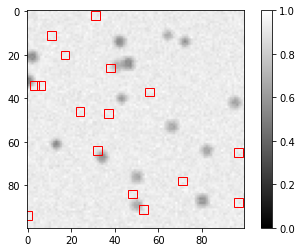

Image(array([[97.57126156, 56.3110939 ],
       [51.3257219 , 24.76505885],
       [67.72359545, 92.31995361],
       [ 7.56311368, 11.79542328],
       [15.7782257 , 46.65158206],
       [98.21888432, 24.89980369],
       [12.00909764,  5.31945986],
       [18.7865272 , 68.5456782 ],
       [15.9046413 , 80.12604377],
       [54.78129819, 64.0388787 ],
       [67.58081786, 92.48722735],
       [10.79537612,  2.96433477],
       [26.84843305, 59.06155339],
       [ 6.22840454, 27.89107783],
       [75.35207174, 45.6377607 ],
       [43.45578896, 18.22800863],
       [37.09380997, 73.61102194],
       [ 2.09640285, 11.93322528],
       [13.90331153, 79.03106991],
       [60.13112343,  9.0531073 ],
       [86.88458606, 17.90109657]]))
Image(array([[97.57126156, 56.3110939 ],
       [51.3257219 , 24.76505885],
       [67.72359545, 92.31995361],
       [ 7.56311368, 11.79542328],
       [15.7782257 , 46.65158206],
       [98.21888432, 24.89980369],
       [12.00909764,  5.31945986],
      

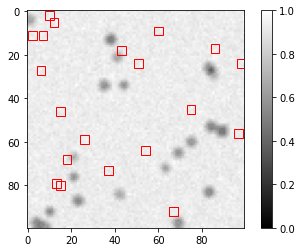

Image(array([[ 0.45689122, 51.35920309],
       [84.60816458, 90.72148655],
       [13.77360686, 49.69867999],
       [94.60592624, 46.08548616],
       [42.81797216, 67.49516315],
       [ 7.33910337, 85.70656229],
       [ 5.54033002,  3.56573103],
       [69.84291316, 53.72441306],
       [43.49901333,  1.7976504 ],
       [81.81826121,  2.70730319],
       [57.53665113, 92.54996174],
       [48.23998626, 53.10531104],
       [ 1.30294917, 40.53099534],
       [69.32705431, 95.48502201],
       [72.18034082, 65.01889304],
       [ 0.46743226, 93.9123711 ],
       [28.56753269, 42.03630185],
       [48.02343392,  6.15361252],
       [68.15072816, 22.67957514],
       [69.78275576,  9.55578734],
       [77.34912588, 61.2034493 ],
       [94.62578198, 49.92675682]]))
Image(array([[ 0.45689122, 51.35920309],
       [84.60816458, 90.72148655],
       [13.77360686, 49.69867999],
       [94.60592624, 46.08548616],
       [42.81797216, 67.49516315],
       [ 7.33910337, 85.70656229],
      

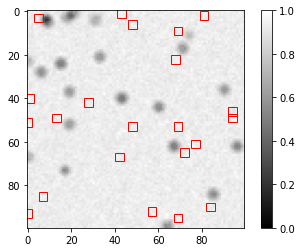

In [191]:
NUMBER_OF_IMAGES = 5

for _ in range(NUMBER_OF_IMAGES):
    particle.update()
    a = pos.update()
    #b = rad.update()
    #print(a.resolve())
    label = a >> get_label#(a, b)
    label = label.resolve()
    print(label)
    image_of_particle = particle.resolve()
    

    
    n = np.shape(label)[0]
    position_of_particles = label[:,0:2]
    print(position_of_particles)
    radius_of_particles = label[:,2] 
    
    plt.imshow(image_of_particle, cmap="gray", vmin = 0)
    plt.colorbar()
    ax = plt.gca()
    for i in range(int(n)):
        rect = plt.Rectangle((label[i,0]-label[i,2],label[i,1]-label[i,2]),2*label[i,2],2*label[i,2],linewidth=1,edgecolor='r',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
    
    
    #plt.scatter(position_of_particles[:,0], position_of_particles[:,1], marker='+', edgecolors="r", linewidth=2)
    plt.show()

In [ ]:
from deeptrack.models.yolo.yolo import YOLOv3

model = YOLOv3(
    (256, 256, 1),
    2,
)

model.compile(optimizer="adam")

In [ ]:
from deeptrack.models.yolo.dataset import YoloDataGenerator

generator = YoloDataGenerator(
    feature=data,
    input_size=np.array([256]),
    num_class=2,
    label_function=lambda d: np.array(d[1:]),
    batch_size=4,
    min_data_size=100,
    max_data_size=200,
)

generator.anchors = model.anchors